In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm

import datetime
import copy
import json

import sys
sys.path.append('../../')

from data.dataloader import Covid19IndiaLoader
# from data.processing import get_data
from data.processing import granular, processing

from models.seir.seir_testing import SEIR_Testing
from models.seir.seirhd import SEIRHD
from models.seir.seir_movement import SEIR_Movement
from models.seir.seir_movement_testing import SEIR_Movement_Testing

from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv
from utils.create_report import create_report
from utils.loss import Loss_Calculator
from viz import plot_forecast

In [29]:
from utils.smooth_jump import *
from viz import plot_smoothing

## Assign Filename var

In [118]:
filename = '../../data/data/mumbai/case_summary_2006.csv'

In [119]:
strat_filename = '../../data/data/mumbai/case_summary_expanded_2006.csv'

In [120]:
df_strat = granular.get_data(filename=strat_filename)

In [121]:
df = processing.get_data(filename=filename, disable_tracker=True)

In [122]:
df

,date,state,district,total_infected,hospitalised,recovered,deceased
0,2020-04-11,Maharashtra,Mumbai,1182,1036,71,75
1,2020-04-12,Maharashtra,Mumbai,1399,1211,97,91
2,2020-04-13,Maharashtra,Mumbai,1549,1308,141,100
3,2020-04-14,Maharashtra,Mumbai,1753,1478,164,111
4,2020-04-15,Maharashtra,Mumbai,1936,1642,181,113
...,...,...,...,...,...,...,...
66,2020-06-16,Maharashtra,Mumbai,60142,25937,31040,3165
67,2020-06-17,Maharashtra,Mumbai,61501,26921,31338,3242
68,2020-06-18,Maharashtra,Mumbai,62799,27634,31856,3309
69,2020-06-19,Maharashtra,Mumbai,64068,28388,32257,3423


In [123]:
df_smoothed = smooth_big_jump(df)

6191
smoothing length truncated to 33
3139
smoothing length truncated to 17
-891
smoothing length truncated to 18
917
smoothing length truncated to 65


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


True


In [247]:
df_strat_smoothed = copy.copy(df_strat)

diff_array = df_smoothed.loc[df_smoothed['date'].isin(df_strat['date']), 'hospitalised'].reset_index(drop=True) - df_strat['hospitalised']

for column in df_strat_smoothed.loc[:, 'stable_asymptomatic':].columns:
    df_strat_smoothed[column] += diff_array*(df_strat_smoothed[column]/df_strat_smoothed['hospitalised'])

base_columns = ['total_infected', 'hospitalised', 'recovered', 'deceased']
df_strat_smoothed.loc[:, base_columns] = df_smoothed.loc[df_smoothed['date'].isin(df_strat['date']), base_columns].reset_index(drop=True)

In [248]:
all_compartments = ['total_infected', 'hospitalised', 'recovered', 'deceased', 'stable_asymptomatic', 'stable_symptomatic', 'critical', 'hq', 'non_o2_beds', 'o2_beds', 'icu', 'ventilator']

In [249]:
d1 = '2020-06-10'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'stable_symptomatic', 'stable_asymptomatic', d1, smoothing_length=length, method='weighted')

d1 = '2020-06-15'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'stable_asymptomatic', 'stable_symptomatic', d1, smoothing_length=length, method='weighted')

2836.0185888244523
smoothing length truncated to 18
-944.9446101088415
smoothing length truncated to 23


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [250]:
d1 = '2020-06-15'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'ventilator', 'icu', d1, smoothing_length=length, method='weighted-mag')

237.26438795288504
smoothing length truncated to 23


In [251]:
d1 = '2020-06-15'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'icu', 'o2_beds', d1, smoothing_length=length, method='weighted-mag')

d1 = '2020-05-31'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'icu', 'o2_beds', d1, smoothing_length=length, method='weighted-mag')

274.0
smoothing length truncated to 23
375.0
smoothing length truncated to 8


In [252]:
d1 = '2020-06-08'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'o2_beds', 'non_o2_beds', d1, smoothing_length=length, method='weighted-mag')

d1 = '2020-06-14'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'o2_beds', 'non_o2_beds', d1, smoothing_length=length, method='weighted-mag')

d1 = '2020-06-15'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'o2_beds', 'non_o2_beds', d1, smoothing_length=length, method='weighted-mag')

-296.0
smoothing length truncated to 16
649.0
smoothing length truncated to 22
1750.0
smoothing length truncated to 23


In [253]:
d1 = '2020-05-28'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'non_o2_beds', 'hq', d1, smoothing_length=length, method='weighted-mag')

d1 = '2020-05-31'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'non_o2_beds', 'hq', d1, smoothing_length=length, method='weighted-mag')

1502.0
smoothing length truncated to 5
2007.0
smoothing length truncated to 8


In [254]:
d1 = '2020-06-14'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'non_o2_beds', 'o2_beds', d1, smoothing_length=length, method='weighted-mag')

d1 = '2020-06-19'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'non_o2_beds', 'o2_beds', d1, smoothing_length=length, method='weighted-mag')

795.0
smoothing length truncated to 22
865.0
smoothing length truncated to 27


In [255]:
d1 = '2020-06-09'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'hq', 'non_o2_beds', d1, smoothing_length=length, method='weighted-mag')

d1 = '2020-06-17'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'hq', 'non_o2_beds', d1, smoothing_length=length, method='weighted-mag')

769.995156407922
smoothing length truncated to 17
1280.0
smoothing length truncated to 25


In [256]:
d1 = '2020-06-17'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'non_o2_beds', 'hq', d1, smoothing_length=length, method='weighted-mag')

760.0
smoothing length truncated to 25


In [258]:
d1 = '2020-06-14'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'o2_beds', 'non_o2_beds', d1, smoothing_length=length, method='weighted-mag')

862.0
smoothing length truncated to 22


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [262]:
d1 = '2020-06-14'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'non_o2_beds', 'hq', d1, smoothing_length=length, method='weighted-mag')

d1 = '2020-06-15'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'non_o2_beds', 'hq', d1, smoothing_length=length, method='weighted-mag')

d1 = '2020-06-09'
length = (datetime.datetime.strptime(d1, '%Y-%m-%d') - df_strat_smoothed.loc[0, 'date']).days
df_strat_smoothed = smooth_big_jump_helper(
    df_strat_smoothed, 'non_o2_beds', 'hq', d1, smoothing_length=length, method='weighted-mag')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f496b96a790>,
      dtype=object)

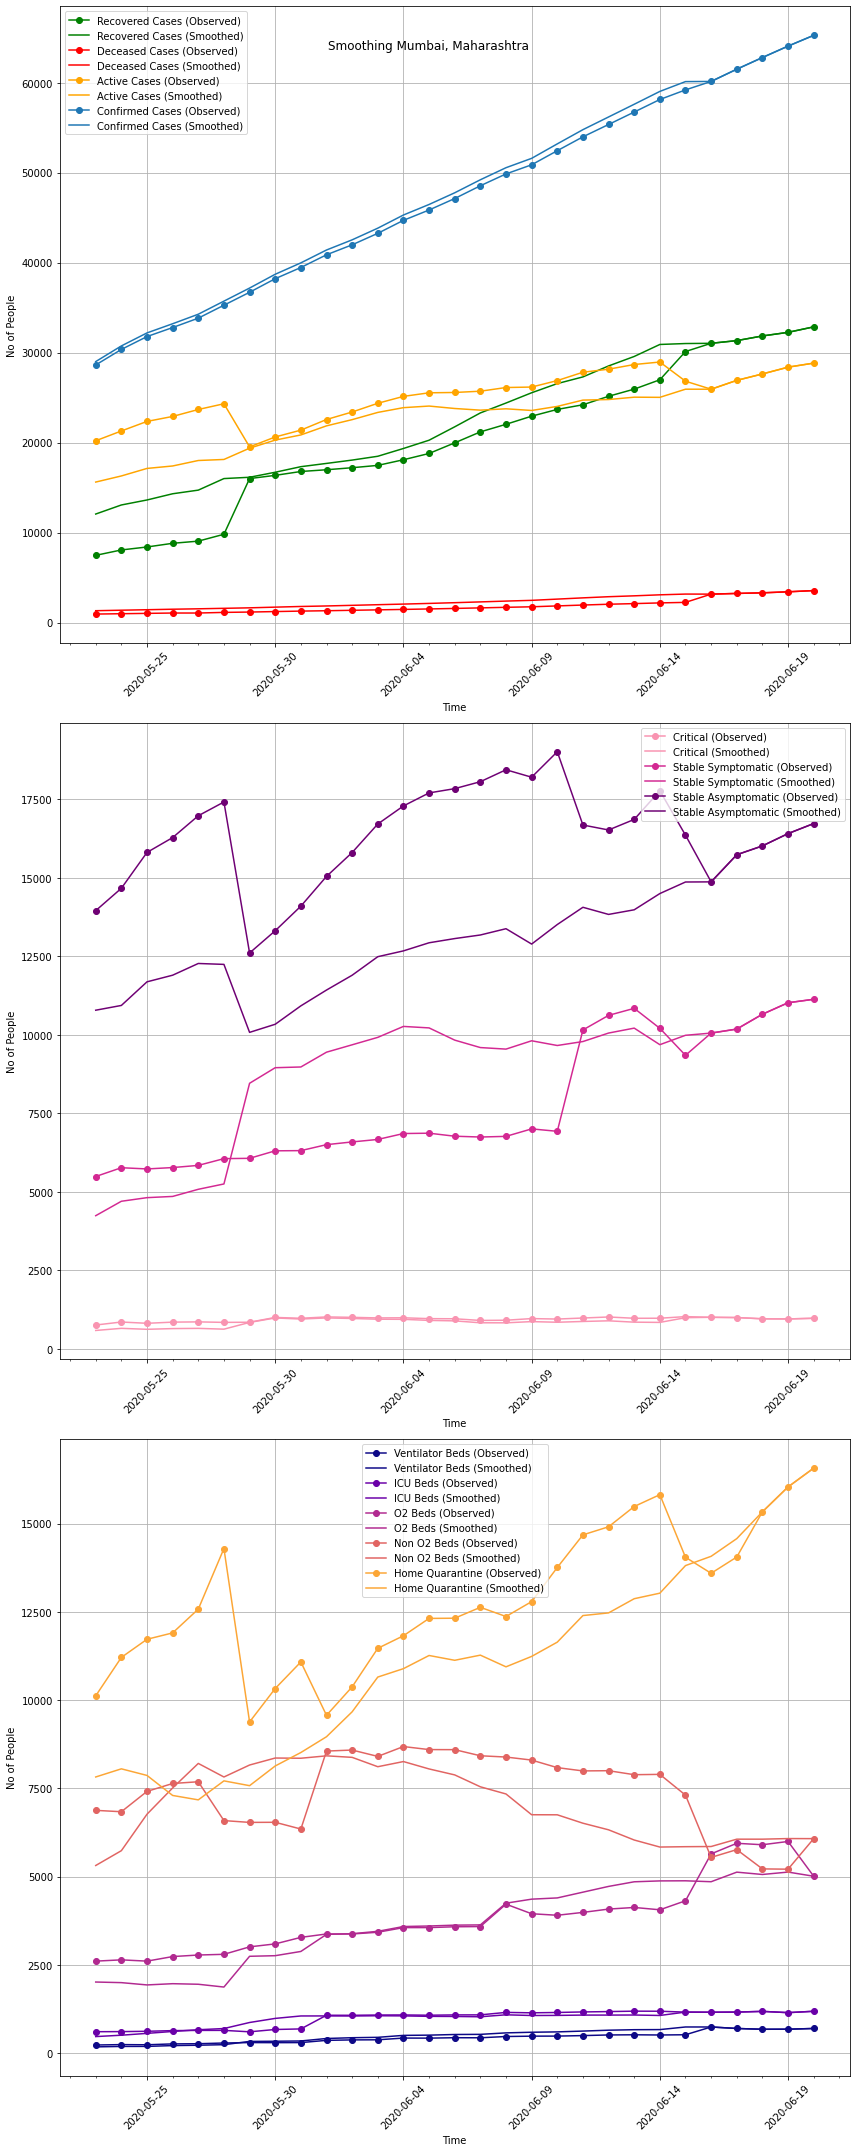

In [263]:
plot_smoothing(df_strat, df_strat_smoothed, 'Maharashtra', 'Mumbai', which_compartments=all_compartments, description='Smoothing')